# Исследование поведения пользоватеелй мобильного приложения по продаже продуктов питания

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше. Для этого выполнить шаги:

Шаг 1. Откройте файл с данными и изучите общую информацию

Шаг 2. Подготовьте данные

Шаг 3. Изучите и проверьте данные

Шаг 4. Изучите воронку событий

Шаг 5. Изучите результаты эксперимента

## Откройте файл с данными и изучите общую информацию

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import numpy as np
import math as mth
import plotly.graph_objects as go
import plotly.express as px
%pip install -U kaleido -q
import plotly.io as pio
pio.renderers.default = "png"


pd.set_option('chained_assignment', None)

Note: you may need to restart the kernel to use updated packages.


In [2]:
#прочитаем файл и запишем в переменную
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

except:
    display('File not found')

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.

    EventName — название события;
    DeviceIDHash — уникальный идентификатор пользователя;
    EventTimestamp — время события;
    ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Подготовка данных

In [4]:
#переименуем колонки
data.rename(columns =
            {'EventName':'event_name',
             'DeviceIDHash':'device_id',
             'EventTimestamp':'event_ts',
             'ExpId':'group'},
            inplace = True)

In [5]:
#проверим на пропуски
data.isna().mean()

event_name    0.0
device_id     0.0
event_ts      0.0
group         0.0
dtype: float64

In [6]:
#проверим на дубликаты
data.duplicated().sum()

413

In [7]:
#удаление дубликатов
data = data.drop_duplicates()

In [8]:
#смотрим тип данных
data.dtypes

event_name    object
device_id      int64
event_ts       int64
group          int64
dtype: object

In [9]:
#переведём данные в нужный тип
data['event_dt'] = pd.to_datetime(data['event_ts'],unit='s')

data['date'] = data['event_dt'].dt.date 

data['group'] = data['group'].astype(str)

data

,event_name,device_id,event_ts,group,event_dt,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


## Изучим и проверим данные

In [10]:
#всего событий в логе
len(data['event_name'])

243713

In [11]:
#всего уникальных пользователей
data['device_id'].nunique()

7551

In [12]:
#число событий на пользователя в среднем
data.groupby('device_id').agg({'event_name':'count'}).reset_index()['event_name'].mean()

32.27559263673685

In [13]:
#минимальная и максимальная дата в логе
print('Минимальная дата:', data['date'].min())

print('Максимальная дата:', data['date'].max())

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07


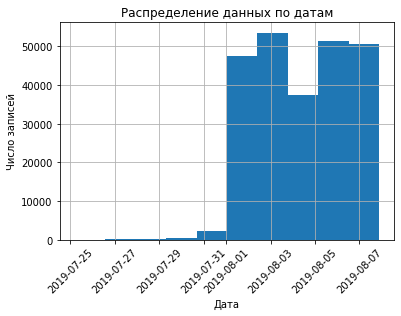

In [14]:
#смотрим распределение данных
data['event_dt'].hist(xrot=45)
plt.title('Распределение данных по датам')
plt.xlabel('Дата')
plt.ylabel('Число записей');

Эксперимент скорее всего шёл неделю с 1-го по 7-ое августа 2019 года, поэтому данные, которые не попадают в этот промежуток, могут исказить выводы. Их нужно отбросить:

In [15]:
data = data.query('event_dt >= "2019-08-01"')

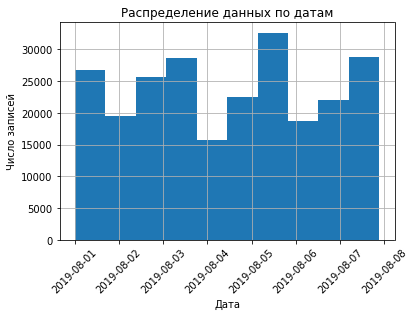

In [16]:
data['event_dt'].hist(xrot=45);
plt.title('Распределение данных по датам')
plt.xlabel('Дата')
plt.ylabel('Число записей');

In [17]:
data['device_id'].nunique() / 7551 - 1, len(data) / 244126 -1

(-0.0022513574361011646, -0.013267738790624484)

По итогу отбросили около 0.2% пользователей и примерно 1.3% всех событий в логе.

In [18]:
#число пользователей в группах
data.groupby('group').agg({'device_id':'nunique'}).reset_index()

,group,device_id
0,246,2484
1,247,2513
2,248,2537


In [19]:
#смотрим, есть ли пересечения между группами
data.query('group == 246 or group == 247')['device_id'].drop_duplicates().isin(data.query('group == 248')['device_id']).sum()

0

In [20]:
data.query('group == 246')['device_id'].drop_duplicates().isin(data.query('group == 247')['device_id']).sum()

0

Пересечений нет.

## Изучение воронки событий

In [21]:
#смотрим частотность событий по всему логу
data['event_name'].value_counts(normalize=True).round(3)

MainScreenAppear           0.487
OffersScreenAppear         0.192
CartScreenAppear           0.176
PaymentScreenSuccessful    0.141
Tutorial                   0.004
Name: event_name, dtype: float64

Основная часть событий, почти 50%, приходится на главную страницу приложения. Менее всего событий пришлось на обучение пользованию магазином. Похоже, пользователи его пропускают.

In [22]:
#считаем, сколько пользователей совершало каждое событие и долю от общего числа пользователей
events_usrs = data.groupby('event_name').agg({'device_id':'nunique'}).reset_index().sort_values('device_id',ascending=False)

events_usrs['%ids'] = (events_usrs['device_id'] / data['device_id'].nunique()*100).round(2)

events_usrs

,event_name,device_id,%ids
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Предположим, что события происходят в следующем порядке: MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful. То есть, пользователь заходит на главный экран приложения, переходит на страницу товара, добавляет товар в корзину, переходит на экран корзины и оплачивает покупку. Обучение учитывать не будем, его в основном пропускают.  	

In [23]:
events_usrs = events_usrs.query('event_name != "Tutorial"')

In [24]:
#считаем долю пользователей, проходящих каждый шаг воронки продаж
events_usrs['%step'] = (events_usrs['device_id']*100 / events_usrs['device_id'].shift(1, fill_value = events_usrs['device_id'].iloc[0])).round(2)

events_usrs

,event_name,device_id,%ids,%step
1,MainScreenAppear,7419,98.47,100.00
2,OffersScreenAppear,4593,60.96,61.91
0,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


Отметим, что от общего числа пользователей до первого платежа доходит около 47%.

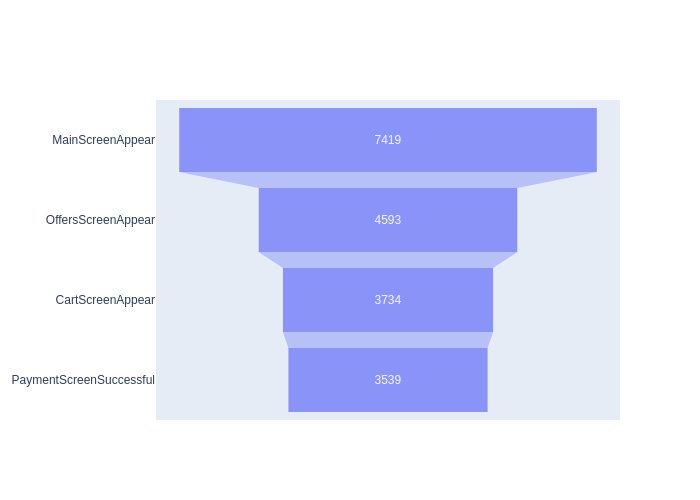

In [26]:
#строим воронку событий
fig = go.Figure(go.Funnel(
    x = events_usrs['device_id'],
    y = events_usrs['event_name'],
    opacity = 0.7
    ))

fig.show()

Видно, что большая часть пользователей теряется при переходе с главной страницы на страницу товара, остаётся около 61% всех пользователей. Зато от страницы товара до добавления товара в корзину и оплаты доходит 81% и 95% пользователей соответственно.

## Изучение результатов эксперимента

In [27]:
#число пользователей в группах
groups = data.groupby('group').agg({'device_id':'nunique'}).reset_index()

#добавляем объединённую контрольную группу
groups = groups.append({'group':'249','device_id':2484+2513}, ignore_index=True)

groups

,group,device_id
0,246,2484
1,247,2513
2,248,2537
3,249,4997


In [28]:
#считаем пользователей с разбивкой по событиями и группам
events_grps = data.pivot_table(index='event_name', values='device_id', columns='group', aggfunc='nunique').reset_index()

events_grps = events_grps.query('event_name != "Tutorial"')

#добавляем объединённую контрольную группу
events_grps['249'] = events_grps['246'] + events_grps['247']

events_grps

group,event_name,246,247,248,249
0,CartScreenAppear,1266,1238,1230,2504
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
3,PaymentScreenSuccessful,1200,1158,1181,2358


Самое популярное событие - вход на главный экран

In [29]:
#определим функцию для проведения теста на равенство долей
def z_test(group1, group2, event, alpha=0.05):
    #доли пользователей в группах при событии event
    successes1 = events_grps[events_grps['event_name']==event][group1].iloc[0]
    successes2 = events_grps[events_grps['event_name']==event][group2].iloc[0]
    
    #общее количество наблюдений в группах
    trials1 = groups[groups['group']== group1]['device_id'].iloc[0]
    trials2 = groups[groups['group']== group2]['device_id'].iloc[0]
    
    #пропорция успехов в первой группе
    p1 = successes1/trials1

    #пропорция успехов во второй группе
    p2 = successes2/trials2

    #пропорция успехов в комбинированном датасете
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    #разница пропорций в датасетах
    difference = p1 - p2
    
    #считаем статистику в ст.отклонениях стандартного нормального распределения   
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1) 

    #значение p для двухсторонней гипотезы
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница для события", event, 'для групп', group1, 'и', group2)
    else:
        print("Не получилось отвергнуть нулевую гипотезу для события", event, 'для групп', group1, 'и', group2)  

Проверим, есть ли различия между долями пользователей в событии MainScreenAppear в контрольных группах. Формулируем гипотезы:

H_0: Между долями пользователей групп **нет** статистических различий.

H_a: Между долями пользователей групп **есть** статистические различия.

Уровень значимости = 0.05

In [30]:
z_test('246', '247', 'MainScreenAppear', alpha=0.05)

p-value:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear для групп 246 и 247


Похоже, что между долями события MainScreenAppear в контрольных группах нет статистической разницы. Проверим для остальных событий:

In [31]:
for i in events_grps['event_name'].unique():
    z_test('246', '247', i, alpha=0.05)

p-value:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear для групп 246 и 247
p-value:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear для групп 246 и 247
p-value:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear для групп 246 и 247
p-value:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful для групп 246 и 247


Похоже, что контрольные группы составлены верно, между их долями нет статистических различий.

In [32]:
#проверяем стат. разницу между контрольной группой и группой с изменённым шрифтом
for i in events_grps['event_name'].unique():
    z_test('246', '248', i, alpha=0.05)

p-value:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear для групп 246 и 248
p-value:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear для групп 246 и 248
p-value:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear для групп 246 и 248
p-value:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful для групп 246 и 248


Между контрольной группой 246 и группой с изменённым шрифтом нет стат. различий.

In [33]:
for i in events_grps['event_name'].unique():
    z_test('247', '248', i, alpha=0.05)

p-value:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear для групп 247 и 248
p-value:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear для групп 247 и 248
p-value:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear для групп 247 и 248
p-value:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful для групп 247 и 248


Между контрольной группой 247 и группой с изменённым шрифтом нет стат. различий.

In [34]:
for i in events_grps['event_name'].unique():
    z_test('248', '249', i, alpha=0.05)

p-value:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear для групп 248 и 249
p-value:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear для групп 248 и 249
p-value:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear для групп 248 и 249
p-value:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful для групп 248 и 249


Между объединёнными контрольными группами и экспериментальной группой стат. различий нет. Похоже, что изменение шрифта не привело к увеличению конверсии в покупки.

Если использовать уровень значимости 0.1 (см.ниже), получатся не равны группы 246 и 248 в событии на странице корзины. Конверсия в 246 группе будет 1230/2484 = 51%, в 248 группе 1230/2537 = 49%. В итоге -2% разницы. Учитывая, что в остальных проверках различий нет и то что группы численно не равны, скорее всего это на уровне погрешности.

In [35]:
for i in events_grps['event_name'].unique():
    z_test('246', '248', i, alpha=0.1)

p-value:  0.07842923237520116
Отвергаем нулевую гипотезу: между долями есть значимая разница для события CartScreenAppear для групп 246 и 248
p-value:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear для групп 246 и 248
p-value:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear для групп 246 и 248
p-value:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful для групп 246 и 248


Поскольку было проведено множество проверок, имеет смысл скорректировать уровень значимости. Применим поправку Бонферрони, т.е разделим уровень значимости на число гипотез:

In [36]:
for i in events_grps['event_name'].unique():
    z_test('246', '247', i, alpha=0.05/16)

p-value:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear для групп 246 и 247
p-value:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear для групп 246 и 247
p-value:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear для групп 246 и 247
p-value:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful для групп 246 и 247


In [37]:
for i in events_grps['event_name'].unique():
    z_test('246', '248', i, alpha=0.05/16)

p-value:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear для групп 246 и 248
p-value:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear для групп 246 и 248
p-value:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear для групп 246 и 248
p-value:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful для групп 246 и 248


In [38]:
for i in events_grps['event_name'].unique():
    z_test('247', '248', i, alpha=0.05/16)

p-value:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear для групп 247 и 248
p-value:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear для групп 247 и 248
p-value:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear для групп 247 и 248
p-value:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful для групп 247 и 248


In [39]:
for i in events_grps['event_name'].unique():
    z_test('249', '248', i, alpha=0.05/16)

p-value:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу для события CartScreenAppear для групп 249 и 248
p-value:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу для события MainScreenAppear для групп 249 и 248
p-value:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу для события OffersScreenAppear для групп 249 и 248
p-value:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу для события PaymentScreenSuccessful для групп 249 и 248


Результат не изменился, изменение шрифта всё также не оказало эффекта, разницы между контрольными и экспериментальной группой нет.

## Общий вывод

Был проанализирован лог приложения по продаже продуктов питания с данными о событиях.

Перед анализом выполнена предобработка данных, переименованы названия колонок, данные соответствующих столбцов переведены в нужный формат. Проверен тип данных в столбцах, проверено наличие пропусков и дубликатов. Устранены аномальные данные, выхоящие за рамки теста.

В ходе анализа событий выявлены следующие особенности:

* Основная часть событий, почти 50%, приходится на главную страницу приложения. Менее всего событий пришлось на обучение пользованию магазином

* События, предположительно, происходят в следующем порядке: MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful. 

* От общего числа пользователей до первого платежа доходит около 47%

* Большая часть пользователей теряется при переходе с главной страницы на страницу товара, остаётся около 61% всех пользователей. Зато от страницы товара до добавления товара в корзину и оплаты доходит 81% и 95% пользователей соответственно

Были также проанализированы результаты A/A/B теста с примением критерия о равенстве долей, с уровнем значимости 0.05, а также скорректированным по числу проверок гипотез (0.05 / 16). Во всех случаях статистических отличий экспериментальной группы от контрольных не выявлено. Изменение шрифта в приложении, по-видимому, не повлияло на конверсию в покупки.